# Lorenz 63 - ODE


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import equinox as eqx
import xarray as xr

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

## Simulation

In [2]:
batchsize = 1_000
sigma, rho, beta = 10, 28, 2.667
key = jrandom.PRNGKey(42)
state_init, params = L63State.init_state_batch(
    batchsize=batchsize, noise=0.01, sigma=10, rho=28, beta=2.667, key=key
)

l63_model = Lorenz63()

state_init.x.shape

(1000, 1)

## Time Stepping

### Warmup

We need to do a warmup simulation to get the dynamical system to a steady state.

In [4]:
dt = 0.005
t0 = 0.0
t1 = 10.0
dt_save = 0.01
# observe_every = 10
ts = jnp.arange(t0, t1, dt_save)
num_tsteps = len(ts)

saveat = dfx.SaveAt(
    ts=ts,
)

# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)

integration_fn = lambda state: dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

# integration
sol = jax.vmap(integration_fn)(state_init)

sol.ys.x.shape

(1000, 1000, 1)

### Simulation

In [5]:
from tqdm.autonotebook import trange

for i in trange(10):
    # integration
    state_init = eqx.tree_at(lambda x: x.x, state_init, sol.ys.x[:, -1])
    state_init = eqx.tree_at(lambda x: x.y, state_init, sol.ys.y[:, -1])
    state_init = eqx.tree_at(lambda x: x.z, state_init, sol.ys.z[:, -1])

    sol = jax.vmap(integration_fn)(state_init)

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_29690/170991986.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


In [6]:
sol.ts[0, :200].shape, sol.ys.x[:200].shape

((200,), (200, 1000, 1))

In [7]:
ds_sol = xr.Dataset(
    {
        "x": (("realization", "time"), sol.ys.x[:, :200].squeeze()),
        "y": (("realization", "time"), sol.ys.y[:, :200].squeeze()),
        "z": (("realization", "time"), sol.ys.z[:, :200].squeeze()),
    },
    coords={
        "time": (["time"], sol.ts[0, :200].squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_sol

<xarray.Dataset>
Dimensions:  (realization: 1000, time: 200)
Coordinates:
  * time     (time) float32 0.0 0.01 0.02 0.03 0.04 ... 1.95 1.96 1.97 1.98 1.99
Dimensions without coordinates: realization
Data variables:
    x        (realization, time) float32 11.41 10.82 10.21 ... 9.89 9.374 8.853
    y        (realization, time) float32 5.712 4.767 3.925 ... 4.78 4.178 3.657
    z        (realization, time) float32 36.21 35.83 35.34 ... 34.01 33.54 33.01
Attributes:
    ode:      lorenz_63
    sigma:    10
    beta:     2.667
    rho:      28

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


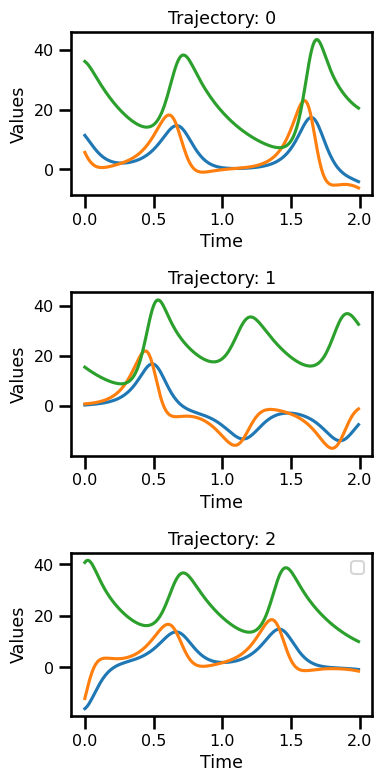

In [8]:
fig, ax = plt.subplots(nrows=3, figsize=(4, 8))

for i in range(3):
    ds_sol.x.sel(
        realization=i,
    ).plot(ax=ax[i])
    ds_sol.y.sel(
        realization=i,
    ).plot(ax=ax[i])
    ds_sol.z.sel(
        realization=i,
    ).plot(ax=ax[i])

    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Values")
    ax[i].set_title(f"Trajectory: {i}")


plt.legend()
plt.tight_layout()
plt.show()

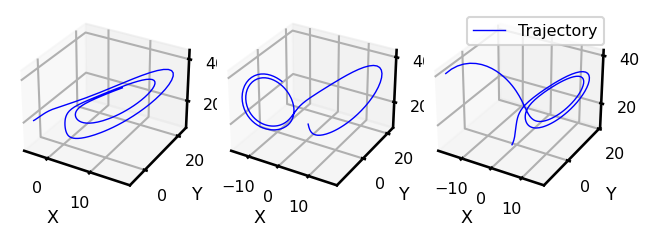

In [9]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.x.sel(
            realization=i,
        ),
        ds_sol.y.sel(
            realization=i,
        ),
        ds_sol.z.sel(
            realization=i,
        ),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")
# ax.scatter3D(out.x[::10], out.y[::10], out.z[::10], lw=0.5, color="red", label="y")


plt.legend()
plt.tight_layout()
plt.show()

## Generating Observations


In [10]:
ds_sol = ds_sol.to_array(dim="component", name="simulation").to_dataset()
ds_sol

<xarray.Dataset>
Dimensions:     (time: 200, component: 3, realization: 1000)
Coordinates:
  * time        (time) float32 0.0 0.01 0.02 0.03 0.04 ... 1.96 1.97 1.98 1.99
  * component   (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation  (component, realization, time) float32 11.41 10.82 ... 33.01

### Missing Time

In [11]:
sample_step = 20
ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)
ds_sol["observations"].loc[..., ::sample_step] = ds_sol["simulation"].loc[
    ..., ::sample_step
]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


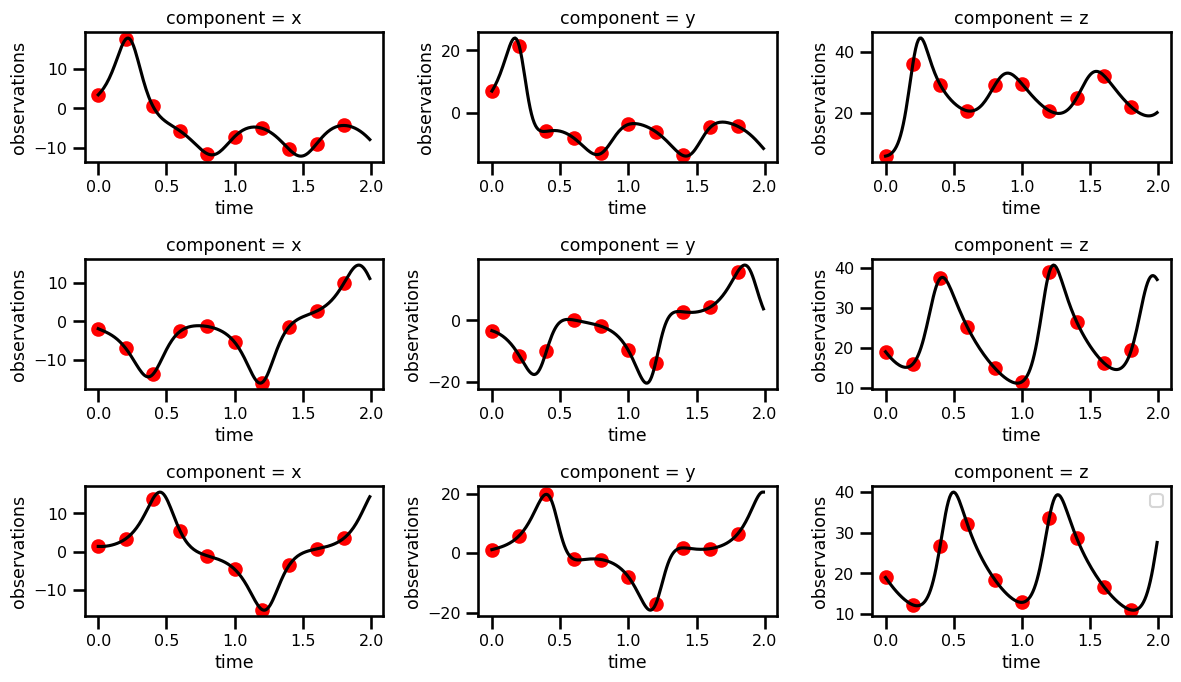

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

for i in range(0, 3):
    ds_sol.simulation.sel(realization=i + 100, component="x").plot(
        ax=ax[i, 0], color="black"
    )
    ds_sol.observations.sel(realization=i + 100, component="x").plot.scatter(
        ax=ax[i, 0], color="red"
    )

    ds_sol.simulation.sel(realization=i + 100, component="y").plot(
        ax=ax[i, 1], color="black"
    )
    ds_sol.observations.sel(realization=i + 100, component="y").plot.scatter(
        ax=ax[i, 1], color="red"
    )

    ds_sol.simulation.sel(realization=i + 100, component="z").plot(
        ax=ax[i, 2], color="black"
    )
    ds_sol.observations.sel(realization=i + 100, component="z").plot.scatter(
        ax=ax[i, 2], color="red"
    )


plt.legend()
plt.tight_layout()
plt.show()

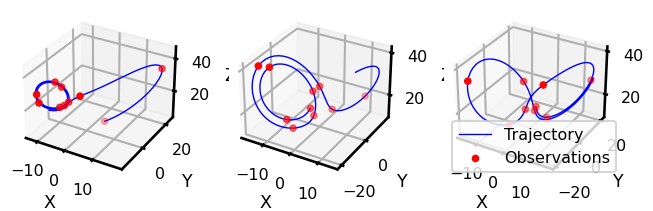

In [13]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.simulation.sel(realization=i + 100, component="x"),
        ds_sol.simulation.sel(realization=i + 100, component="y"),
        ds_sol.simulation.sel(realization=i + 100, component="z"),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].scatter(
        ds_sol.observations.sel(realization=i + 100, component="x"),
        ds_sol.observations.sel(realization=i + 100, component="y"),
        ds_sol.observations.sel(realization=i + 100, component="z"),
        lw=1.0,
        color="red",
        label="Observations",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")


plt.legend()
plt.tight_layout()
plt.show()

### Adding Noise

In [14]:
# def add_noise(da, sigma=2**.5):
#     return da  + np.random.randn(*da.shape) * sigma

sigma = 2.0

ds_sol["observations_noise"] = ds_sol["observations"] + sigma * np.random.randn(
    *ds_sol["observations"].shape
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


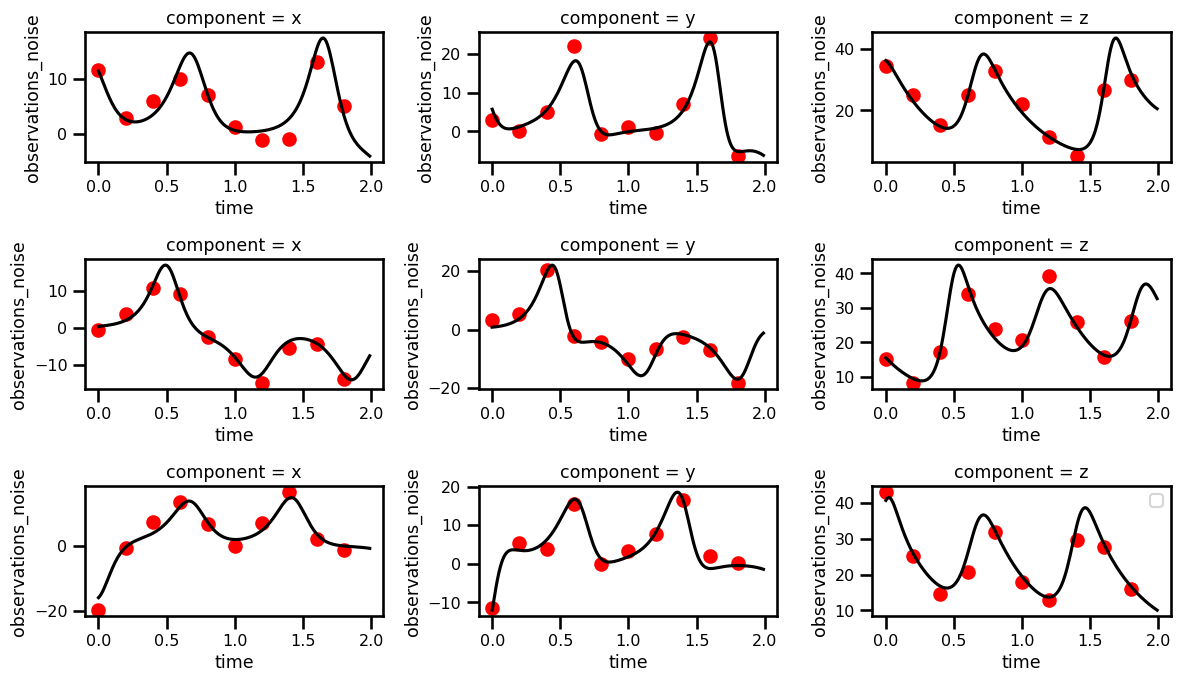

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

for i in range(3):
    ds_sol.simulation.sel(realization=i, component="x").plot(ax=ax[i, 0], color="black")
    ds_sol.observations_noise.sel(realization=i, component="x").plot.scatter(
        ax=ax[i, 0], color="red"
    )

    ds_sol.simulation.sel(realization=i, component="y").plot(ax=ax[i, 1], color="black")
    ds_sol.observations_noise.sel(realization=i, component="y").plot.scatter(
        ax=ax[i, 1], color="red"
    )

    ds_sol.simulation.sel(realization=i, component="z").plot(ax=ax[i, 2], color="black")
    ds_sol.observations_noise.sel(realization=i, component="z").plot.scatter(
        ax=ax[i, 2], color="red"
    )


plt.legend()
plt.tight_layout()
plt.show()

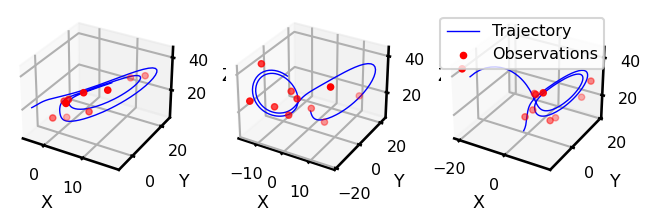

In [16]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.simulation.sel(realization=i, component="x"),
        ds_sol.simulation.sel(realization=i, component="y"),
        ds_sol.simulation.sel(realization=i, component="z"),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].scatter(
        ds_sol.observations_noise.sel(realization=i, component="x"),
        ds_sol.observations_noise.sel(realization=i, component="y"),
        ds_sol.observations_noise.sel(realization=i, component="z"),
        lw=1.0,
        color="red",
        label="Observations",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")


plt.legend()
plt.tight_layout()
plt.show()

## Initial Interpolation

In [17]:
import scipy
from tqdm.autonotebook import trange

variable_name = "observations_interp"

ds_sol[variable_name] = xr.full_like(ds_sol.observations_noise, np.nan)


for i in trange(ds_sol.simulation.shape[1]):
    dataarray = ds_sol["observations_noise"].sel(realization=i)

    # interpolate nans
    dataarray = dataarray.interpolate_na(
        dim="time", method="slinear", fill_value="extrapolate"
    )

    # set
    ds_sol[variable_name].loc[:, i, :] = dataarray

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1822.28it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


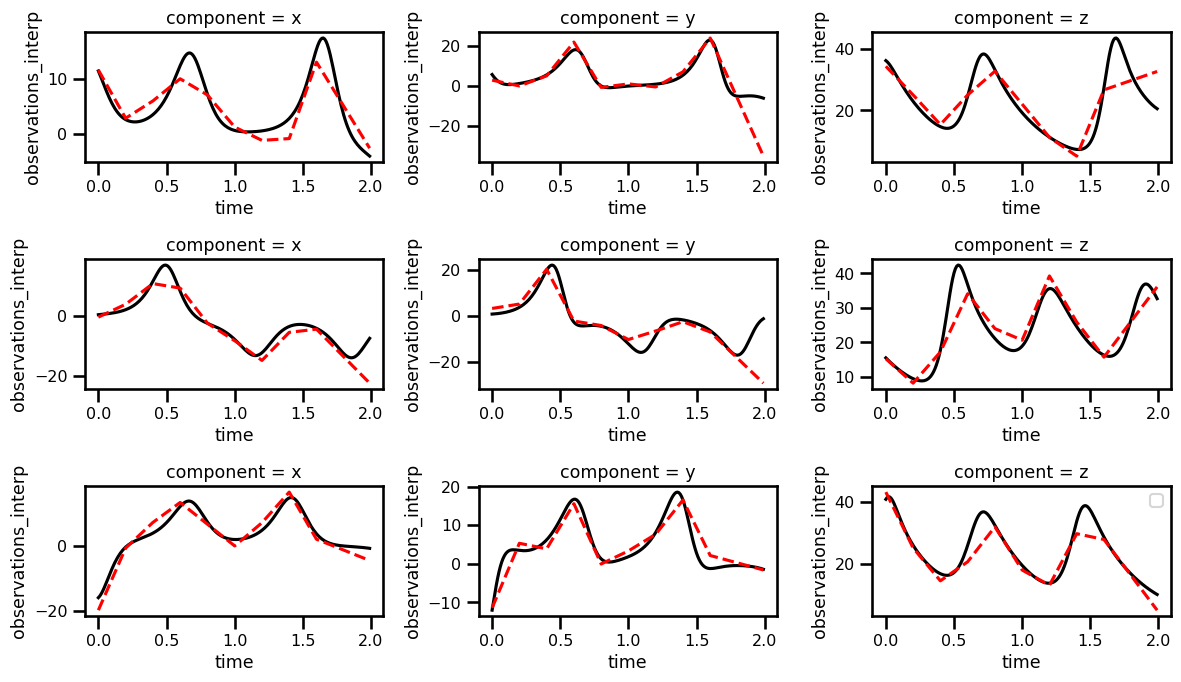

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

for i in range(3):
    ds_sol.simulation.sel(realization=i, component="x").plot(ax=ax[i, 0], color="black")
    ds_sol.observations_interp.sel(realization=i, component="x").plot(
        ax=ax[i, 0], color="red", linestyle="--"
    )

    ds_sol.simulation.sel(realization=i, component="y").plot(ax=ax[i, 1], color="black")
    ds_sol.observations_interp.sel(realization=i, component="y").plot(
        ax=ax[i, 1], color="red", linestyle="--"
    )

    ds_sol.simulation.sel(realization=i, component="z").plot(ax=ax[i, 2], color="black")
    ds_sol.observations_interp.sel(realization=i, component="z").plot(
        ax=ax[i, 2], color="red", linestyle="--"
    )


plt.legend()
plt.tight_layout()
plt.show()

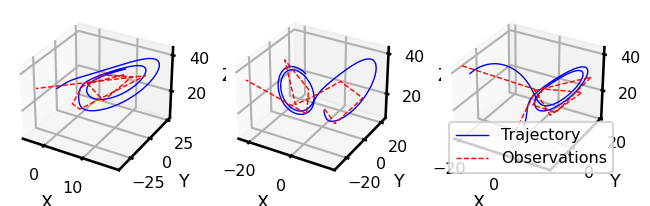

In [19]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        ds_sol.simulation.sel(realization=i, component="x"),
        ds_sol.simulation.sel(realization=i, component="y"),
        ds_sol.simulation.sel(realization=i, component="z"),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].plot(
        ds_sol.observations_interp.sel(realization=i, component="x"),
        ds_sol.observations_interp.sel(realization=i, component="y"),
        ds_sol.observations_interp.sel(realization=i, component="z"),
        lw=1.0,
        linestyle="--",
        color="red",
        label="Observations",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")


plt.legend()
plt.tight_layout()
plt.show()

## Inverse Problem

In [20]:
realization = 100

ds_trajectory = ds_sol.sel(realization=realization)
ds_trajectory

<xarray.Dataset>
Dimensions:              (time: 200, component: 3)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Data variables:
    simulation           (component, time) float32 3.473 3.838 ... 19.88 20.22
    observations         (component, time) float32 3.473 nan nan ... nan nan nan
    observations_noise   (component, time) float64 2.271 nan nan ... nan nan nan
    observations_interp  (component, time) float64 2.271 2.981 ... 13.83 13.37

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


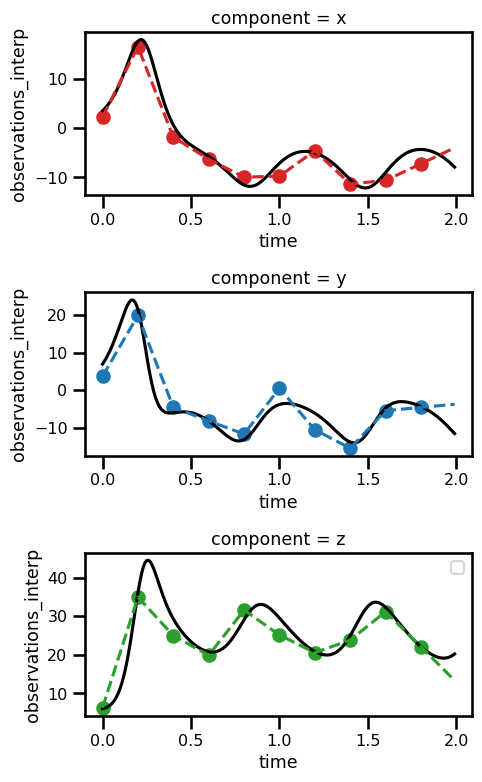

In [21]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))


ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

ds_trajectory.observations_noise.sel(component="x").plot.scatter(
    ax=ax[0], color="tab:red"
)
ds_trajectory.observations_noise.sel(component="y").plot.scatter(
    ax=ax[1], color="tab:blue"
)
ds_trajectory.observations_noise.sel(component="z").plot.scatter(
    ax=ax[2], color="tab:green"
)

ds_trajectory.observations_interp.sel(component="x").plot(
    ax=ax[0], color="tab:red", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="y").plot(
    ax=ax[1], color="tab:blue", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="z").plot(
    ax=ax[2], color="tab:green", linestyle="--"
)

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

In [178]:
# Ground Truth
x_state = jnp.asarray(ds_trajectory.simulation.values).T
ts_state = jnp.asarray(ds_trajectory.time.values)
# Observations
y_gt = jnp.asarray(ds_trajectory.observations_noise.values).T
# Mask
y_mask = 1.0 - (
    jnp.isnan(jnp.asarray(ds_trajectory.observations_noise.values))
    .astype(jnp.float32)
    .T
)
# initialization
x_init = jnp.asarray(ds_trajectory.observations_interp.values).T

x_state.shape, y_gt.shape, y_mask.shape, x_init.shape

((200, 3), (200, 3), (200, 3), (200, 3))

#### Time Batches

Here, we need to do a method that's able to time step one at a time.
So we need to unravel the array such that we get the 2 time steps, the start and the finish.
We can use the `kernex` library to loop over the array and keeping the time steps one at a time.

In [23]:
import kernex as kex


@kex.kmap(kernel_size=(2,), relative=True)
def time_patches(x):
    return x


ts_batches = time_patches(ts_state)
ts_state.shape, ts_batches.shape, x_state.shape

((200,), (199, 2), (200, 3))

In [24]:
ts_batches[1], ts_state[:2], ts_batches[0]

(Array([0.01, 0.02], dtype=float32),
 Array([0.  , 0.01], dtype=float32),
 Array([0.  , 0.01], dtype=float32))

## Dynamical Prior

Here, we define our dynamical prior which we plug into this loss function.

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
||\boldsymbol{u} - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$

Our dynamical prior in this case is defined by:

$$
\boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta}) \coloneqq
\boldsymbol{u}(t_1) =
\boldsymbol{u}(t_0) + \int_{t_0}^{t_1}
\boldsymbol{F}\left( \boldsymbol{u}(t),\tau;\boldsymbol{\theta}\right)d\tau 
$$



**Weak Constrained**

The weak-constrained version works as a "one-step" prediction whereby we step through the trajectory with the ODE solver one at a time.


$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
$$

In [55]:
import typing as tp
from jaxtyping import PyTree, Array, ArrayLike

Solver = dfx.AbstractSolver
StepSize = dfx.AbstractAdaptiveStepSizeController


class DynamicalPrior(eqx.Module):
    params: eqx.Module = eqx.static_field()
    model: tp.Callable
    solver: Solver
    stepsize: StepSize

    def __init__(
        self,
        params: PyTree,
        model: tp.Callable,
        solver: Solver = dfx.Tsit5(),
        stepsize: StepSize = dfx.PIDController(rtol=1e-5, atol=1e-5),
    ):
        self.params = params
        self.model = model
        self.solver = solver
        self.stepsize = stepsize

    def init_state(self, x: Array) -> PyTree:
        state = L63State(x=x[0], y=x[1], z=x[2])

        return state

    def __call__(
        self,
        x: Array,
        ts: Array,
        dt: tp.Optional[float] = None,
        params: tp.Optional[PyTree] = None,
    ) -> PyTree:
        t0 = ts[0]
        t1 = ts[-1]

        # time step
        if dt is None:
            dt = ts[1] - ts[0]

        # initialize state
        state = self.init_state(x=x)

        saveat = dfx.SaveAt(ts=jnp.asarray([t1]))

        sol = dfx.diffeqsolve(
            terms=dfx.ODETerm(l63_model.equation_of_motion),
            solver=self.solver,
            t0=t0,
            t1=t1,
            dt0=dt,
            y0=state,
            saveat=saveat,
            args=params if params is not None else self.params,
            stepsize_controller=self.stepsize,
        )

        return sol.ys

    def loss(self, x: Array, ts: Array, x_gt: tp.Optional[Array] = None) -> Array:
        """Dynamical Loss Function for Prior operator

        Eqn:
            R(u;θ) = || u - ϕ(u;θ)||

        Args:
            x (Array): an array of states, [timesteps, variables]
            ts (Array): an array of times, [timesteps, ]
            x_gt (Array): an array of true states, [timesteps, variables]

        Returns:
            loss (Array): a loss scalar value for the dynamical cost function
        """
        if x_gt is None:
            x_gt = x
        # create t batches
        ts = time_patches(ts)

        # check sizes
        msg = f"Size Mismatch: \n{x.shape} | {ts.shape} | {x_gt.shape}"
        assert len(x) - 1 == len(ts) == len(x_gt) - 1, msg

        # dynamical one-step predictions
        x_pred = jax.vmap(self, in_axes=(0, 0), out_axes=(0))(x[:-1], ts)

        # return an array
        x_pred = x_pred.array

        # mean squared error
        loss = jnp.sum((x_pred - x_gt[1:]) ** 2)
        return loss

In [56]:
prior = DynamicalPrior(params=params, model=l63_model.equation_of_motion)

In [57]:
out = jax.vmap(prior, in_axes=(0, 0))(x_state[1:], ts_batches)
out.x.shape

(199, 1)

#### Sanity Check

In this sanity check, we're going to compare two losses:
a) one set of inputs will be the true state propagated through the 1 step ODE model and
b) one loss of inputs will be the state initialized via the naive interpolation scheme.

In prinicpal, the absolute loss value should be **more** for the state initialized with the naive interpolation.

In [58]:
x_state.T.shape, ts.shape

((3, 200), (1000,))

In [59]:
loss_true = prior.loss(x=x_state, ts=ts_state)

loss_init = prior.loss(x=x_init, ts=ts_state)

loss_init_state = prior.loss(x=x_init, ts=ts_state, x_gt=x_state)

# check hypothesis
assertion = loss_init > loss_true

msg = f"Loss\n----"
msg = f""
msg += f"\nInit+True State: {loss_init:.2f}"
print(
    f"Loss\n----"
    + f"\nTrue State: {loss_true:.2f}"
    + f"\nInit State: {loss_init:.2f}"
    + f"\nInit+True State: {loss_init_state:.2f}"
    + f"\nLess: {assertion}"
)

Loss
----
True State: 0.00
Init State: 149.64
Init+True State: 6352.21
Less: True


We see that this is the case!

**Note**: The loss is not exactly zero as one might initially suspect.
However, this may be the case because we are stepping iteratively one-step at a time instead of simply predicting using the full trajectory.
This may have some accumulated error somewhere in these many steps.

### Learning

In this instance, we're going to use a simple gradient descent scheme.

$$
\boldsymbol{u}^{(k+1)} =
\boldsymbol{u}^{(k)} +
\alpha \boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

where $\alpha$ is the learning rate and $\boldsymbol{\nabla_u}$ is the gradient operator wrt the state, $\boldsymbol{u}$.
We have an optimality condition of the gradient of the variational cost.

$$
\boldsymbol{F_g}(\boldsymbol{u};\boldsymbol{\theta}) =
\boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

Because we are doing gradient *descent*, we will use a negative learning rate of $\alpha=-0.1$.

For this first part, we're simply going to use the variational cost as the dynamical prior.

$$
\begin{aligned}
\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta}) &=
\boldsymbol{R}(\boldsymbol{u};\boldsymbol{\theta}) \\
&=
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
\end{aligned}
$$

In [60]:
# create grad loss function
grad_loss_fn = jax.jit(jax.value_and_grad(prior.loss, has_aux=False))

In [31]:
# # get gradient wrt state
# (loss, losses), grad = grad_loss_fn(x_init, ts_state, x_state)

# loss.shape, grad.shape, losses

In [61]:
# get gradient wrt state
loss, grad = grad_loss_fn(x_init, ts_state)

loss.shape, grad.shape

((), (200, 3))

In [62]:
from tqdm.autonotebook import trange

losses = []
num_iterations = 30_000
learning_rate = -0.2
x = x_init.copy()
# # x_gt = x_init
# x_gt = x_state.copy()

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:
        # get dynamical loss + gradient
        loss, x_grad = grad_loss_fn(x, ts_state)

        pbar.set_description(f"Loss: {loss:.2e}")
        losses.append(loss)

        # update solution with gradient
        x += learning_rate * x_grad

Loss: 5.89e-04: 100%|██████████| 30000/30000 [00:27<00:00, 1091.55it/s]


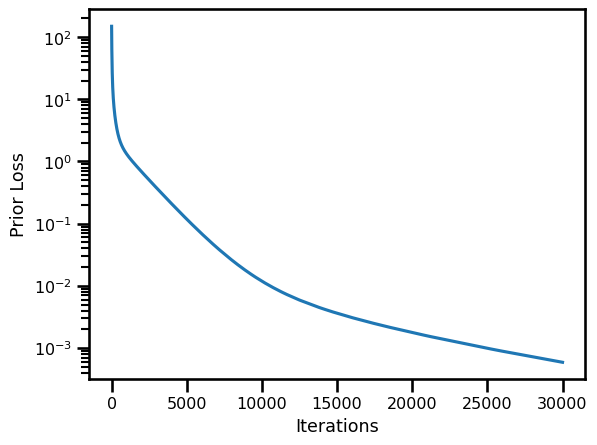

In [63]:
fig, ax = plt.subplots()

ax.plot(losses)

ax.set(yscale="log", xlabel="Iterations", ylabel="Prior Loss")
plt.show()

In [64]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float32 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float32 5.267 5.434 5.688 ... 19.22 19.52
    state           (component, time) float32 3.473 3.838 4.24 ... 19.88 20.22
    initialization  (component, time) float32 2.271 2.981 3.69 ... 13.83 13.37
    observation     (component, time) float32 2.271 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


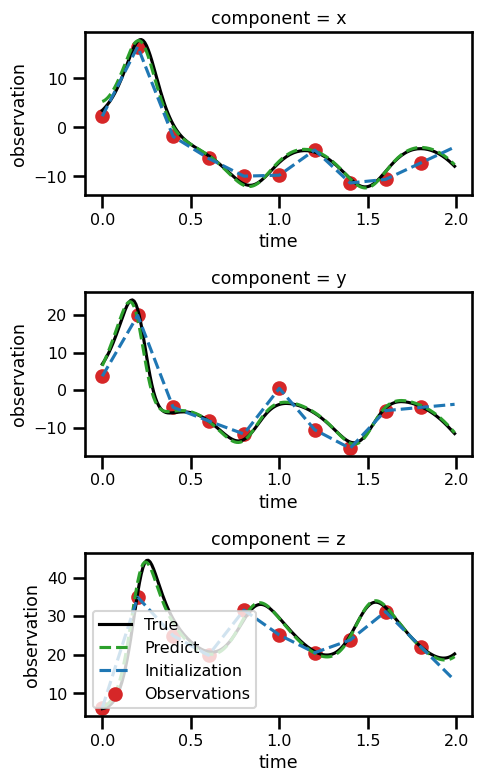

In [65]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="--", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle="--", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    # ax[axis].scatter(ts_state[y_mask], y_gt[:, axis][y_mask], linestyle="--", color="tab:green", label="Observations")
    # ax[axis].plot(ts_state, x_init[:, axis], linestyle="--", color="tab:blue", label="Initialization")
    # ax[axis].plot(ts_state, x[:, axis], color="black", linestyle="--", label="Predict")
    plt.legend()


# ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
# ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
# ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

# ds_trajectory.observations_noise.sel(component="x").plot.scatter(ax=ax[0], color="tab:red")
# ds_trajectory.observations_noise.sel(component="y").plot.scatter(ax=ax[1], color="tab:blue")
# ds_trajectory.observations_noise.sel(component="z").plot.scatter(ax=ax[2], color="tab:green")

# ds_trajectory.observations_interp.sel(component="x").plot(ax=ax[0], color="tab:red", linestyle="--")
# ds_trajectory.observations_interp.sel(component="y").plot(ax=ax[1], color="tab:blue", linestyle="--")
# ds_trajectory.observations_interp.sel(component="z").plot(ax=ax[2], color="tab:green", linestyle="--")

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


# plt.legend()
plt.tight_layout()
plt.show()

In [123]:
from jaxopt import OptaxSolver
import optax

prior = DynamicalPrior(params=params, model=l63_model.equation_of_motion)

losses = dict(prior=list(), obs=list(), bg=list())


# initialize variational cost function


def fun(params, **kwargs):
    return prior.loss(x=params, **kwargs)


learning_rate = 5e-3

In [128]:
num_iterations = 1_000
warmup_steps = 250

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-3,
    warmup_steps=warmup_steps,
    decay_steps=num_iterations - warmup_steps,
    end_value=5e-5,
)

# schedule = optax.exponential_decay(
#   init_value=0.2,
#   transition_steps=num_iterations,
#   decay_rate=0.1,
#   end_value=5e-6,
# )

optimizer = optax.chain(
    optax.clip(2.0),
    # optax.sgd(learning_rate=schedule),
    # optax.adam(learning_rate=schedule),
    optax.adamw(learning_rate=schedule),
)

optimizer = optax.sgd(learning_rate=learning_rate)

In [129]:
# opt = optax.adam(learning_rate)
solver = OptaxSolver(opt=optimizer, fun=fun, maxiter=num_iterations, has_aux=True)

x = 0.5 * x_init.copy()
xb = x_state[0].copy()

opt_state = solver.init_state(
    init_params=x,
    ts=ts_state,
    x_gt=x,
)

# # params = init_params


# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:
        # get gradient wrt state
        x, opt_state = solver.update(
            x,
            opt_state,
            ts=ts_state,
            x_gt=x,
        )

        loss = opt_state.aux

        losses["prior"].append(loss["prior"])

        pbar_msg = f"Prior - {loss['prior']:.2e}"
        pbar.set_description(pbar_msg)

  0%|          | 0/1000 [00:00<?, ?it/s]

Prior - 6.04e+02: 100%|██████████| 1000/1000 [00:14<00:00, 69.52it/s]


#### Loss Curve

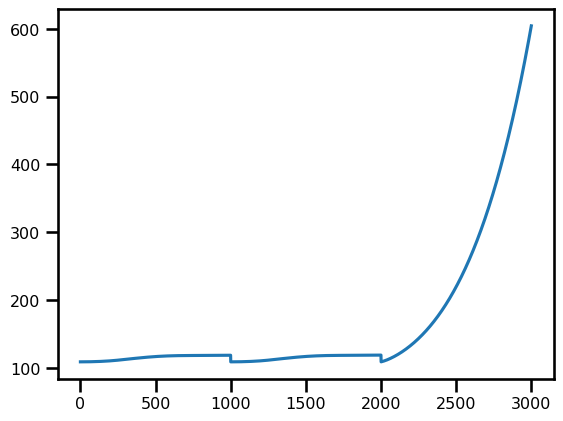

In [130]:
fig, ax = plt.subplots()

ax.plot(losses["prior"])

# ax.set(yscale="log", xscale="log")
plt.show()

In [131]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float32 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float32 -5.257 -5.221 ... 6.995 6.761
    state           (component, time) float32 -2.693 -2.503 ... 23.89 25.05
    initialization  (component, time) float32 -4.063 -4.153 ... 14.02 13.52
    observation     (component, time) float32 -4.063 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


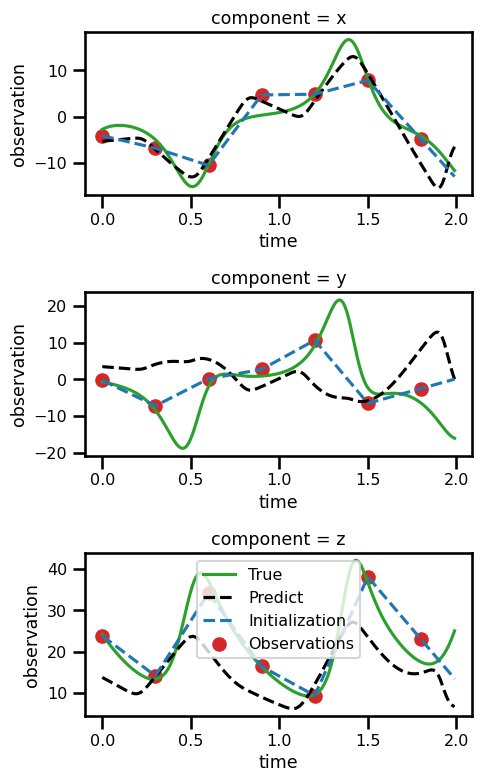

In [135]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="--", color="black", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle="--", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    # ax[axis].scatter(ts_state[y_mask], y_gt[:, axis][y_mask], linestyle="--", color="tab:green", label="Observations")
    # ax[axis].plot(ts_state, x_init[:, axis], linestyle="--", color="tab:blue", label="Initialization")
    # ax[axis].plot(ts_state, x[:, axis], color="black", linestyle="--", label="Predict")
    plt.legend()


# ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
# ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
# ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

# ds_trajectory.observations_noise.sel(component="x").plot.scatter(ax=ax[0], color="tab:red")
# ds_trajectory.observations_noise.sel(component="y").plot.scatter(ax=ax[1], color="tab:blue")
# ds_trajectory.observations_noise.sel(component="z").plot.scatter(ax=ax[2], color="tab:green")

# ds_trajectory.observations_interp.sel(component="x").plot(ax=ax[0], color="tab:red", linestyle="--")
# ds_trajectory.observations_interp.sel(component="y").plot(ax=ax[1], color="tab:blue", linestyle="--")
# ds_trajectory.observations_interp.sel(component="z").plot(ax=ax[2], color="tab:green", linestyle="--")

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


# plt.legend()
plt.tight_layout()
plt.show()

## Observation Operator

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{H}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$


We can use a simpler loss function which is just a masking operator.

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{u}||_{\Omega_{obs}}^2
$$

where $\Omega_{obs}$ is the domain of the observation.

In [183]:
def observation_loss(x, y, mask):
    # nans to numbers
    y = jnp.nan_to_num(y)

    loss = jnp.sum(mask * (x - y) ** 2)
    # loss = jnp.linalg.norm(mask * (x - y), axis=0).sum()

    return loss

In [184]:
observation_loss(x_init, y_gt, y_mask)

Array(0., dtype=float32)

In [66]:
class Identity(eqx.Module):
    def __call__(self, x):
        return x


class Likelihood(eqx.Module):
    operator: tp.Callable

    def __init__(self, operator: tp.Callable = Identity):
        self.operator = operator

    def __call__(self, x: Array) -> Array:
        return self.operator(x)

    def loss(self, x: Array, y: Array, mask: tp.Optional[Array] = None) -> Array:
        # nans to numbers
        y = jnp.nan_to_num(y)

        if mask is not None:
            loss = jnp.sum(mask * (x - y) ** 2)
        else:
            loss = jnp.sum((x - y) ** 2)

        return loss

In [180]:
class VariationalCost(eqx.Module):
    prior: tp.Callable = eqx.static_field()
    obs_op: tp.Callable = eqx.static_field()
    prior_weight: Array = eqx.static_field()
    obs_op_weight: Array = eqx.static_field()
    background_weight: Array = eqx.static_field()

    def __init__(
        self,
        prior: tp.Callable,
        obs_op: tp.Callable,
        prior_weight: float = 1.0,
        obs_op_weight: float = 0.1,
        background_weight: float = 0.0,
    ):
        self.prior = prior
        self.obs_op = obs_op
        self.prior_weight = jnp.asarray(prior_weight)
        self.obs_op_weight = jnp.asarray(obs_op_weight)
        self.background_weight = jnp.asarray(background_weight)

    def loss(
        self,
        x,
        ts,
        y,
        mask: tp.Optional[Array] = None,
        xb: tp.Optional[Array] = None,
        x_gt: tp.Optional[Array] = None,
        return_loss: bool = False,
    ):
        if x_gt is None:
            x_gt = x

        if xb is None:
            xb = x[0]

        # prior loss
        prior_loss = self.prior.loss(x, ts, x_gt)

        # observation loss
        obs_loss = self.obs_op.loss(x, y, mask)

        # background loss
        background_loss = jnp.sum((x[0] - xb) ** 2)

        # compute variational loss
        var_loss = self.prior_weight * prior_loss
        var_loss += self.obs_op_weight * obs_loss
        var_loss += self.background_weight * background_loss

        # save other costs for auxillary outputs
        if return_loss:
            return var_loss, dict(
                var_loss=var_loss, prior=prior_loss, obs=obs_loss, bg=var_loss
            )
        else:
            return var_loss

In [227]:
# compute initial condition
x = x_init.copy()
x_gt = x_state.copy()

# initialize variational prior
prior = DynamicalPrior(params=params, model=l63_model.equation_of_motion)
# initialize variational likelihood
likelihood = Likelihood()
# initialize variational cost function
varcost_fn = VariationalCost(
    prior=prior,
    obs_op=likelihood,
    prior_weight=1.0,
    obs_op_weight=0.1,
    background_weight=0.0,
)


# compute variational cost
loss_init, losses_init = varcost_fn.loss(
    x=x_init, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True
)
loss_true, losses_true = varcost_fn.loss(
    x=x_state, ts=ts_state, y=y_gt, x_gt=x_state, mask=y_mask, return_loss=True
)
loss_init_true, losses_init_true = varcost_fn.loss(
    x=x_init, ts=ts_state, y=y_gt, x_gt=x_state, mask=y_mask, return_loss=True
)

In [229]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State")
print(losses_init)
print("Init X vs True State")
print(losses_init_true)

True State vs True State
{'var_loss': Array(13.764104, dtype=float32), 'prior': Array(2.111514e-06, dtype=float32), 'obs': Array(137.64102, dtype=float32), 'bg': Array(13.764104, dtype=float32)}
Init X vs Init State
{'var_loss': Array(149.64468, dtype=float32), 'prior': Array(149.64468, dtype=float32), 'obs': Array(0., dtype=float32), 'bg': Array(149.64468, dtype=float32)}
Init X vs True State
{'var_loss': Array(6352.2085, dtype=float32), 'prior': Array(6352.2085, dtype=float32), 'obs': Array(0., dtype=float32), 'bg': Array(6352.2085, dtype=float32)}


### Learning

In [216]:
import functools as ft

# initialize variational prior
prior = DynamicalPrior(params=params, model=l63_model.equation_of_motion)
# initialize variational likelihood
likelihood = Likelihood()
# initialize variational cost function
varcost_fn = VariationalCost(
    prior=prior,
    obs_op=likelihood,
    prior_weight=1.0,
    obs_op_weight=0.1,
    background_weight=0.0,
)

loss_fn = ft.partial(
    varcost_fn.loss, ts=ts_state, y=y_gt, mask=y_mask, xb=x_state[0], return_loss=True
)
# create grad loss function
grad_loss_fn = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

In [217]:
# # get gradient wrt state
# (loss, losses), grad = grad_loss_fn(x_init, ts_state, x_state)

# loss.shape, grad.shape, losses

In [218]:
# # get gradient wrt state
# (loss, losses), grad = grad_loss_fn(x_init,)

# loss.shape, grad.shape, losses

In [219]:
loss

{'bg': Array(22.958567, dtype=float32),
 'obs': Array(6.3749027, dtype=float32),
 'prior': Array(14.056289, dtype=float32),
 'var_loss': Array(22.958567, dtype=float32)}

In [248]:
from tqdm.autonotebook import trange

losses = dict(prior=[], obs=[], bg=[], var_loss=[])
num_iterations = 5_000
learning_rate = -0.2
x = x_init.copy()

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:
        # get dynamical loss + gradient
        (_, loss), x_grad = grad_loss_fn(x)

        losses["var_loss"].append(loss["var_loss"])
        losses["prior"].append(loss["prior"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Prior - {loss['prior']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

        # update solution with gradient
        x += learning_rate * x_grad

Var Loss: 7.28e+00 | Prior - 2.56e+00 | Obs - 4.72e+01 | BG - 7.28e+00: 100%|██████████| 5000/5000 [00:04<00:00, 1031.36it/s]


In [249]:
# compute variational cost
loss_init, losses_init = varcost_fn.loss(
    x=x_init, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True
)
loss_true, losses_true = varcost_fn.loss(
    x=x_state, ts=ts_state, y=y_gt, x_gt=x_state, mask=y_mask, return_loss=True
)
loss_init_true, losses_init_true = varcost_fn.loss(
    x=x_init, ts=ts_state, y=y_gt, x_gt=x_state, mask=y_mask, return_loss=True
)
loss_sol_true, losses_sol_true = varcost_fn.loss(
    x=x, ts=ts_state, y=y_gt, x_gt=x_state, mask=y_mask, return_loss=True
)
loss_sol, losses_sol = varcost_fn.loss(
    x=x, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True
)

In [250]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State")
print(losses_init)
print("Init X vs True State")
print(losses_init_true)
print("Sol State vs True State")
print(losses_sol_true)
print("Sol state")
print(losses_sol)

True State vs True State
{'var_loss': Array(13.764104, dtype=float32), 'prior': Array(2.111514e-06, dtype=float32), 'obs': Array(137.64102, dtype=float32), 'bg': Array(13.764104, dtype=float32)}
Init X vs Init State
{'var_loss': Array(149.64468, dtype=float32), 'prior': Array(149.64468, dtype=float32), 'obs': Array(0., dtype=float32), 'bg': Array(149.64468, dtype=float32)}
Init X vs True State
{'var_loss': Array(6352.2085, dtype=float32), 'prior': Array(6352.2085, dtype=float32), 'obs': Array(0., dtype=float32), 'bg': Array(6352.2085, dtype=float32)}
Sol State vs True State
{'var_loss': Array(615.3148, dtype=float32), 'prior': Array(610.59265, dtype=float32), 'obs': Array(47.221912, dtype=float32), 'bg': Array(615.3148, dtype=float32)}
Sol state
{'var_loss': Array(7.2818346, dtype=float32), 'prior': Array(2.5596435, dtype=float32), 'obs': Array(47.221912, dtype=float32), 'bg': Array(7.2818346, dtype=float32)}


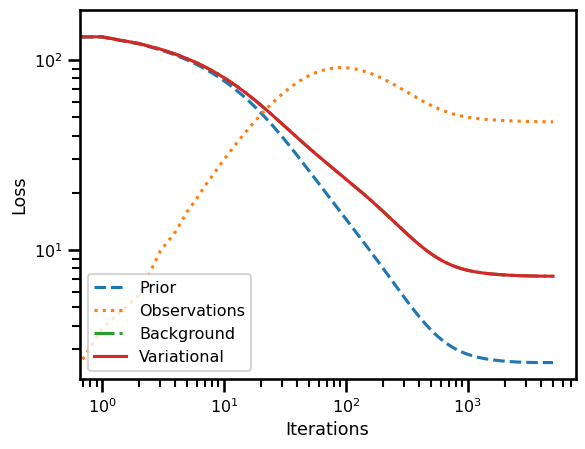

In [251]:
fig, ax = plt.subplots()

ax.plot(losses["prior"], label="Prior", linestyle="--")
ax.plot(losses["obs"], label="Observations", linestyle=":")
ax.plot(losses["bg"], label="Background", linestyle="-.")
ax.plot(losses["var_loss"], label="Variational")

ax.set(yscale="log", xscale="log", xlabel="Iterations", ylabel="Loss")

plt.legend()
plt.show()

In [252]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float32 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float32 3.927 4.232 4.587 ... 21.88 22.29
    state           (component, time) float32 3.473 3.838 4.24 ... 19.88 20.22
    initialization  (component, time) float32 2.271 2.981 3.69 ... 13.83 13.37
    observation     (component, time) float32 2.271 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


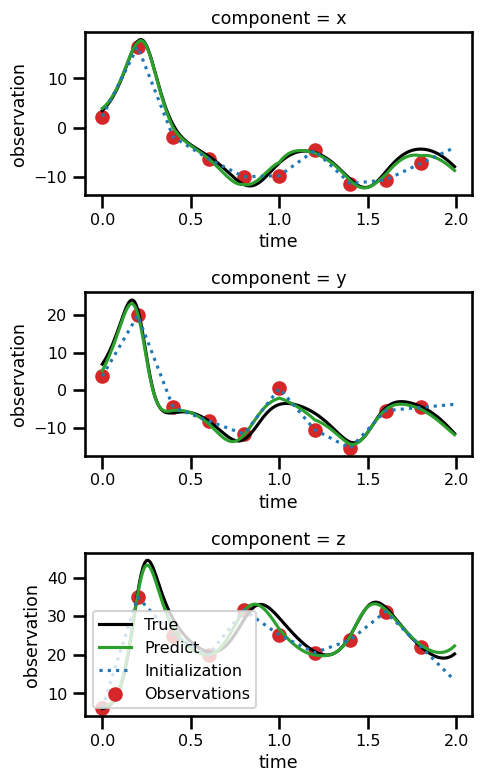

In [255]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle=":", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    # ax[axis].scatter(ts_state[y_mask], y_gt[:, axis][y_mask], linestyle="--", color="tab:green", label="Observations")
    # ax[axis].plot(ts_state, x_init[:, axis], linestyle="--", color="tab:blue", label="Initialization")
    # ax[axis].plot(ts_state, x[:, axis], color="black", linestyle="--", label="Predict")
    plt.legend()


# ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
# ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
# ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

# ds_trajectory.observations_noise.sel(component="x").plot.scatter(ax=ax[0], color="tab:red")
# ds_trajectory.observations_noise.sel(component="y").plot.scatter(ax=ax[1], color="tab:blue")
# ds_trajectory.observations_noise.sel(component="z").plot.scatter(ax=ax[2], color="tab:green")

# ds_trajectory.observations_interp.sel(component="x").plot(ax=ax[0], color="tab:red", linestyle="--")
# ds_trajectory.observations_interp.sel(component="y").plot(ax=ax[1], color="tab:blue", linestyle="--")
# ds_trajectory.observations_interp.sel(component="z").plot(ax=ax[2], color="tab:green", linestyle="--")

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


# plt.legend()
plt.tight_layout()
plt.show()

In [108]:
from jaxopt import OptaxSolver
import optax

losses = dict(prior=list(), obs=list(), bg=list())
num_iterations = 20_000

# initialize variational cost function
varcost = VariationalCost(
    prior=prior, obs_op=likelihood, obs_op_weight=0.0, background_weight=0.0
)


def fun(params, **kwargs):
    return varcost.loss(x=params, **kwargs)


learning_rate = 0.2
opt = optax.adam(learning_rate)
solver = OptaxSolver(opt=opt, fun=fun, maxiter=num_iterations, has_aux=True)

x = x_init.copy()
xb = x_gt[0]

opt_state = solver.init_state(init_params=x, ts=ts, x_gt=x, y=y_gt, mask=y_mask, xb=xb)

# # params = init_params


# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:
        # get gradient wrt state
        x, opt_state = solver.update(
            x, opt_state, ts=ts, x_gt=x, y=y_gt, mask=y_mask, xb=xb
        )

        loss = opt_state.aux

        losses["prior"].append(loss["prior"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Prior - {loss['prior']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

  0%|          | 0/20000 [00:00<?, ?it/s]

Var Loss: 1.92e+05 | Prior - 1.92e+05 | Obs - 1.20e+06 | BG - 1.92e+05:   2%|▏         | 397/20000 [00:07<06:25, 50.81it/s]


KeyboardInterrupt: 

In [109]:
opt_state

OptaxState(iter_num=Array(397, dtype=int32, weak_type=True), value=Array(192253.67, dtype=float32), error=Array(404.17102, dtype=float32), internal_state=(ScaleByAdamState(count=Array(397, dtype=int32), mu=Array([[-4.44733143e+00, -1.89501324e+01,  2.74613895e+01],
       [ 7.02638292e+00,  2.64335709e+01, -1.13435402e+01],
       [ 6.80751514e+00, -6.32499123e+00,  7.78881407e+00],
       [-1.21721931e-01, -8.15379238e+00, -5.45576382e+00],
       [-4.16138554e+00,  1.40964270e+00,  4.12523890e+00],
       [ 5.39418936e-01, -6.42767763e+00,  2.00088096e+00],
       [ 2.79112673e+00, -1.08572092e+01,  8.43989563e+00],
       [ 2.64894795e+00,  3.08078468e-01,  1.34987843e+00],
       [-1.96399093e+00, -8.25592995e+00,  1.30880280e+01],
       [-8.25127029e+00,  1.75211201e+01,  9.61880875e+00],
       [-1.36038332e+01, -3.21585441e+00, -6.59489989e-01],
       [-7.16298163e-01,  2.11437187e+01, -1.43500149e+00],
       [ 4.58167648e+00, -2.26440754e+01,  1.05082474e+01],
       [ 1.882

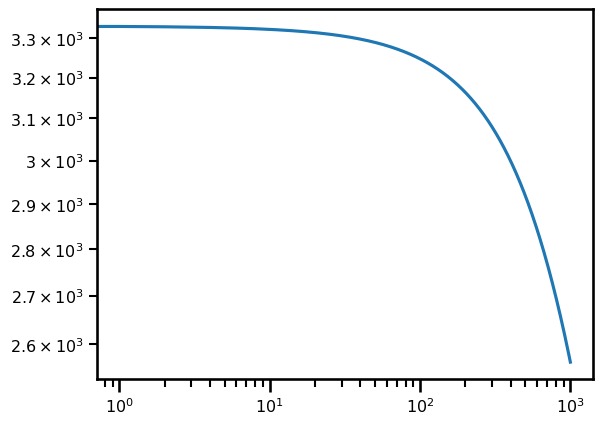

In [101]:
fig, ax = plt.subplots()

ax.plot(losses["prior"])

ax.set(yscale="log", xscale="log")
plt.show()

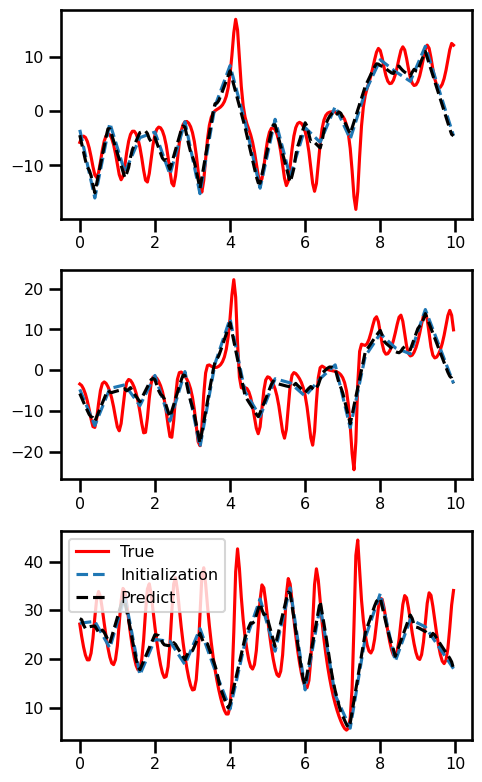

In [102]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ax[axis].plot(ts_state, x_state[:, axis], linestyle="-", color="red", label="True")
    ax[axis].plot(
        ts_state,
        x_init[:, axis],
        linestyle="--",
        color="tab:blue",
        label="Initialization",
    )
    ax[axis].plot(ts_state, x[:, axis], color="black", linestyle="--", label="Predict")


# ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
# ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
# ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

# ds_trajectory.observations_noise.sel(component="x").plot.scatter(ax=ax[0], color="tab:red")
# ds_trajectory.observations_noise.sel(component="y").plot.scatter(ax=ax[1], color="tab:blue")
# ds_trajectory.observations_noise.sel(component="z").plot.scatter(ax=ax[2], color="tab:green")

# ds_trajectory.observations_interp.sel(component="x").plot(ax=ax[0], color="tab:red", linestyle="--")
# ds_trajectory.observations_interp.sel(component="y").plot(ax=ax[1], color="tab:blue", linestyle="--")
# ds_trajectory.observations_interp.sel(component="z").plot(ax=ax[2], color="tab:green", linestyle="--")

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

In [92]:
opt_state.aux

{'var_loss': Array(14774.087, dtype=float32),
 'prior': Array(3330.9917, dtype=float32),
 'obs': Array(114423.81, dtype=float32),
 'bg': Array(14774.087, dtype=float32)}

In [67]:
from tqdm.autonotebook import trange

losses = dict(prior=list(), obs=list(), bg=list())
num_iterations = 20_000
learning_rate = -0.2
x = x_init.copy()
x_gt = x_state.copy()
xb = x_state[0]

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:
        # get gradient wrt state
        x_grad, loss = grad_fn(x, ts, x, y_gt, xb, y_mask)

        losses["prior"].append(loss["prior"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Prior - {loss['prior']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

        # update solution with gradient
        x += learning_rate * x_grad

Var Loss: 1.00e+08 | Prior - 6.46e+07 | Obs - 3.51e+08 | BG - 1.00e+08:   1%|          | 131/20000 [00:01<02:39, 124.27it/s]


KeyboardInterrupt: 

#### Loss Curve

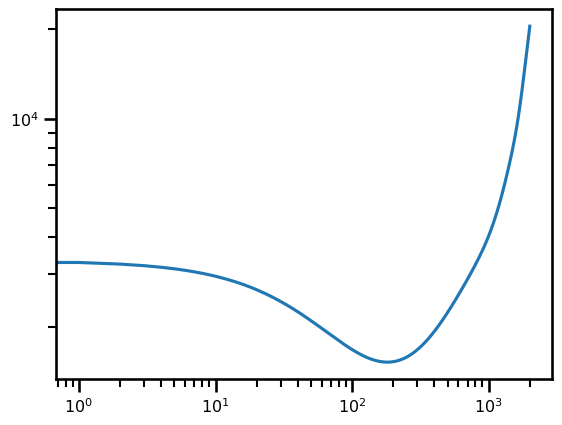

In [63]:
fig, ax = plt.subplots()

ax.plot(losses["prior"])

ax.set(yscale="log", xscale="log")
plt.show()

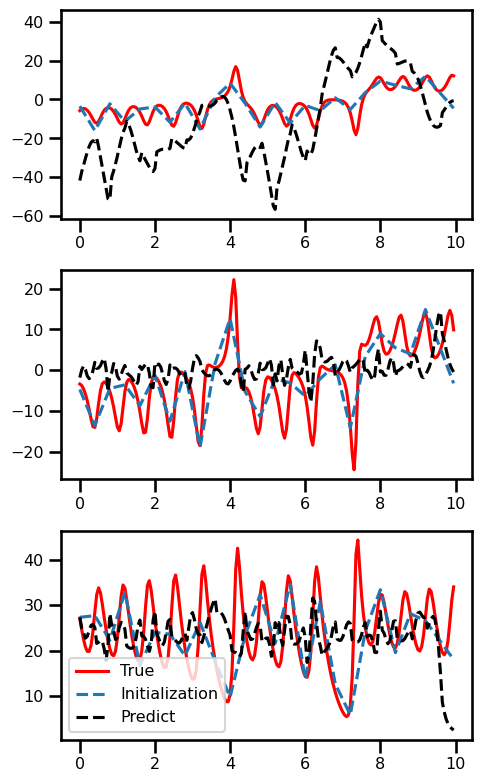

In [64]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ax[axis].plot(ts_state, x_state[:, axis], linestyle="-", color="red", label="True")
    ax[axis].plot(
        ts_state,
        x_init[:, axis],
        linestyle="--",
        color="tab:blue",
        label="Initialization",
    )
    ax[axis].plot(ts_state, x[:, axis], color="black", linestyle="--", label="Predict")


# ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
# ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
# ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

# ds_trajectory.observations_noise.sel(component="x").plot.scatter(ax=ax[0], color="tab:red")
# ds_trajectory.observations_noise.sel(component="y").plot.scatter(ax=ax[1], color="tab:blue")
# ds_trajectory.observations_noise.sel(component="z").plot.scatter(ax=ax[2], color="tab:green")

# ds_trajectory.observations_interp.sel(component="x").plot(ax=ax[0], color="tab:red", linestyle="--")
# ds_trajectory.observations_interp.sel(component="y").plot(ax=ax[1], color="tab:blue", linestyle="--")
# ds_trajectory.observations_interp.sel(component="z").plot(ax=ax[2], color="tab:green", linestyle="--")

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()

In [30]:
y_gt.shape

(3, 200)

In [31]:
y_gt

Array([[-2.33135128e+00,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan, -9.65385532e+00,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -3.32516599e+00,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
        -1.09034758e+01,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan, -5.40158510e+00,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -5.17029381e+00,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
        -1.21743546e+01,             nan,             na

In [32]:
np.ma.masked_array(y_gt[0][1:])

masked_array(data=[         nan,          nan,          nan,          nan,
                            nan,          nan,          nan,  -9.653855  ,
                            nan,          nan,          nan,          nan,
                            nan,          nan,          nan,  -3.325166  ,
                            nan,          nan,          nan,          nan,
                            nan,          nan,          nan, -10.903476  ,
                            nan,          nan,          nan,          nan,
                            nan,          nan,          nan,  -5.401585  ,
                            nan,          nan,          nan,          nan,
                            nan,          nan,          nan,  -5.170294  ,
                            nan,          nan,          nan,          nan,
                            nan,          nan,          nan, -12.174355  ,
                            nan,          nan,          nan,          nan,
                         

IndexError: arrays used as indices must be of integer (or boolean) type

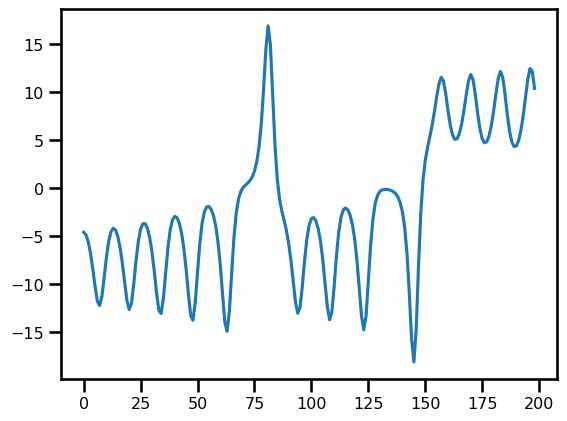

In [33]:
fig, ax = plt.subplots()

ax.plot(
    out.x,
)
ax.plot(np.asarray(y_gt)[0][1:][np.asarray(y_mask)[0][1:]], linestyle=":")
# ax.plot(out.y)
# ax.plot(out.z)

In [ ]:
#
out = time_patches(ts_state)
ts_state.shape, out.shape, x_state.shape

((200,), (199, 2), (3, 200))

In [ ]:
x_state.shape, ts_state.shape

jnp.split(x_state

((3, 200), (200,))

In [ ]:
import typing as tp


class Prior(eqx.Module):
    def __call__(self):
        pass

    def loss(self, true, pred, mask=None):
        pass


class DynamicalPrior(Prior):
    ode: tp.Callable


class ObsOperator(eqx.Module):
    def __call__(self):
        pass

    def loss(self, true, pred, mask=None):
        pass

**Strong Constrained**

The strong-constrained version works by applying the solver directly through the entire trajectory from start to finish.
We are sure to output the state during moments of the trajectory to ensure that we can check to ensure that we can check out how well they match the observations.
So, the function will look something like:

$$
\left[ \boldsymbol{u}_T, \boldsymbol{u}_{T-\Delta t}, \ldots, \boldsymbol{u}_{\Delta t}, \boldsymbol{u}_0\right] = 
\text{ODESolve}\left(\boldsymbol{F}, \boldsymbol{u}_0, T, \Delta t, \boldsymbol{\theta}, \right)
$$

whereby we get a matrix, $\mathbf{U}\in\mathbb{R}^{D_T\times D_u}$, which contains all of the state vectors for every time step of interest.
So our $\boldsymbol{\phi}$ operator will be

$$
\mathbf{U} = \boldsymbol{\phi}(\boldsymbol{u},t;\boldsymbol{\theta})
$$

and our cost function will be

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})_t||_2^2
$$